In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pathlib
from skimage.io import imread
from skimage.transform import resize
import PIL
import pickle
from sklearn.neighbors import NearestNeighbors
import matplotlib.image as mpimg
import tensorflow as tf
print(tf.__version__)
from style_stack import StyleStack
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image


2.3.1


In [4]:
import glob
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
import faiss
from utils import *
import pickle


## Loading Model

In [5]:
data_dir = pathlib.Path('images')

IMG_SIZE = (224, 224)
batch_size = 50

preprocess_input = tf.keras.applications.vgg16.preprocess_input

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset='training',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    subset='validation',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3110 images belonging to 11 classes.
Found 772 images belonging to 11 classes.


In [6]:
weights_file = 'vgg16_furniture_classifier_1129.h5'

base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [7]:
x = base_model.output
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='fc1')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='fc2')(x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(1024, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.2*0.5)(x)
x = tf.keras.layers.Dense(11, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.load_weights(weights_file)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Preparing images path

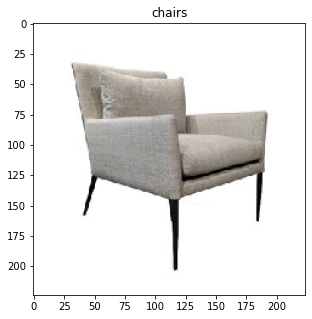

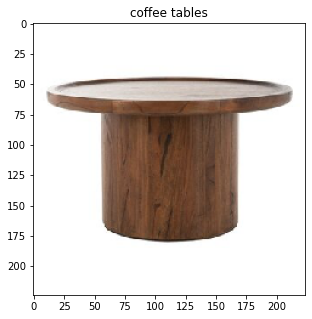

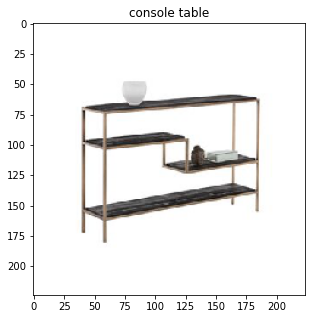

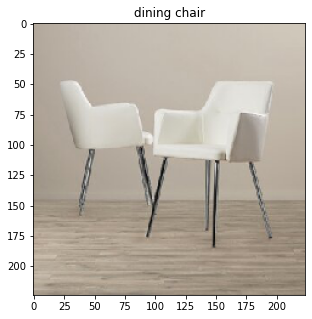

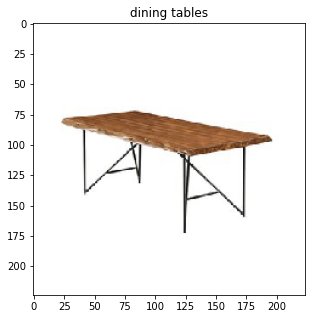

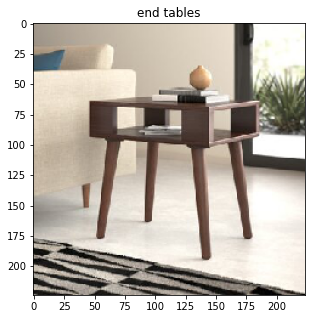

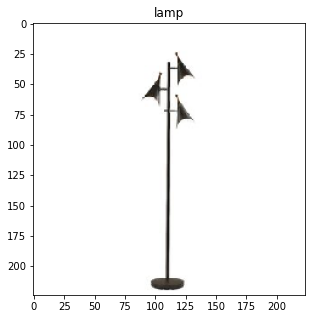

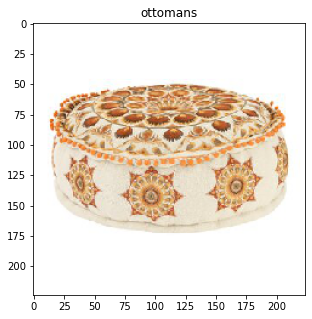

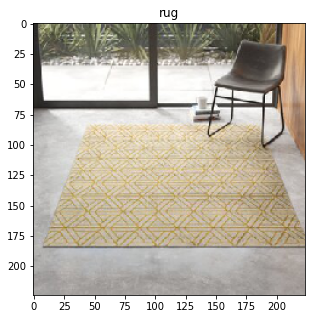

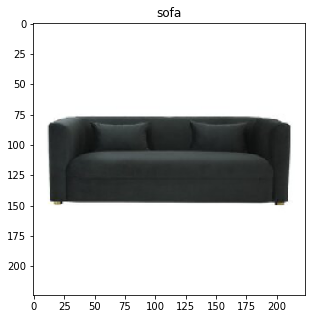

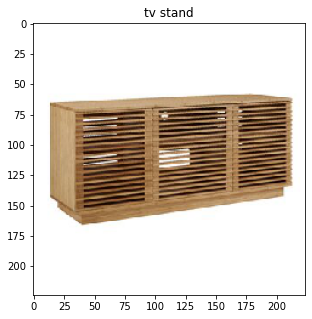

In [8]:
data_dir = pathlib.Path('images')

def get_img_by_class(dir_, class_list):
    img_by_class = {}
    for class_ in class_list:
        paths = glob.glob(os.path.join(dir_, f'{class_}/*'))
        img_by_class[class_] = paths
    return img_by_class


def preview_img_by_class(img_by_class):
    for class_, paths in img_by_class.items():
        img, _ = load_image(paths[0], (224, 224))
        plt.figure(figsize = (5, 5))
        plt.imshow(img)
        plt.title(class_)

dir_ = 'images/'

styles = [
    'chairs',
    'coffee tables',
    'console table',
    'dining chair',
    'dining tables',
    'end tables',
    'lamp',
    'ottomans',
    'rug',
    'sofa',
    'tv stand'
]
                          
art_by_style = get_img_by_class(dir_, styles)
preview_img_by_class(art_by_style)

predicted objects and probabilities
chair 1.9219097e-17
coffee tables 3.019045e-11
console table 6.995447e-14
dining chair 9.884037e-21
end tables 2.3268584e-18
lamp 1.5061389e-12
ottomans 2.9547077e-17
rug 2.2726083e-12
sofa 2.0468925e-17
tv stand 1.8943376e-17


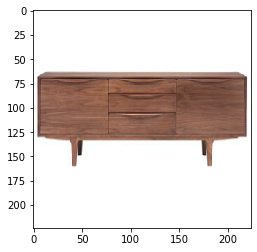

In [124]:
classes = ['chair', 'coffee tables', 'console table', 'dining chair', 'end tables', 'lamp', 'ottomans', 'rug', 'sofa', 'tv stand']
img, x = load_image(art_by_style['tv stand'][2], (224, 224))
plt.imshow(img)
predictions = model.predict(x)
print('predicted objects and probabilities')
for class_, prob in zip(classes, *predictions):
    print(class_, prob)


## Recommendations

In [14]:
fc1_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer('fc1').output)
fc2_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer('fc2').output)
fc1_a = fc1_extractor.predict(x)
fc2_a = fc2_extractor.predict(x)
fc1_norm = preprocessing.normalize(fc1_a, norm='l2')
fc2_norm = preprocessing.normalize(fc2_a, norm='l2')
plt.figure(figsize=(16, 4))
plt.plot(fc1_norm[0], alpha=0.5)
plt.title('normalized fc1 activations')
plt.xlabel('feature number')
plt.ylabel('normalized activation')
plt.figure(figsize=(16, 4))
plt.plot(fc2_norm[0], color='green', alpha=0.5)
plt.title('normalized fc2 activations')
plt.xlabel('feature number')
plt.ylabel('normalized activation')
plt.show()

In [19]:
all_paths = [path for paths in list(art_by_style.values()) for path in paths]
file_mapping = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)
V_2 = fc2_extractor.predict(X)
V_1_norm = preprocessing.normalize(V_1, norm='l2')
V_2_norm = preprocessing.normalize(V_2, norm='l2')

In [211]:
all_paths = [path for path in list(art_by_style['chairs'])]
file_mapping_chairs = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_chair = preprocessing.normalize(V_1, norm='l2')


In [235]:
pickle.dump(file_mapping_chairs, open('file_mapping/chairs/file_mapping_chairs.p', 'wb'))
pickle.dump(V_1_norm_chair, open('file_mapping/chairs/V_1_norm_chair.p', 'wb'))

## Extract feature and normalize vectors for specific category of furnitures

In [207]:
all_paths = [path for path in list(art_by_style['coffee tables'])]
file_mapping_coffee_tables = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_coffee_tables = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_coffee_tables, open('file_mapping/coffee tables/file_mapping_coffee_tables.p', 'wb'))
pickle.dump(V_1_norm_coffee_tables, open('file_mapping/coffee tables/V_1_norm_coffee_tables.p', 'wb'))

In [212]:
all_paths = [path for path in list(art_by_style['console table'])]
file_mapping_console_table = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_console_table = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_console_table, open('file_mapping/console tables/file_mapping_console_table.p', 'wb'))
pickle.dump(V_1_norm_console_table, open('file_mapping/console tables/V_1_norm_console_table.p', 'wb'))


In [213]:
all_paths = [path for path in list(art_by_style['dining chair'])]
file_mapping_dining_chair = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_dining_chair = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_dining_chair, open('file_mapping/dining chair/file_mapping_dining_chair.p', 'wb'))
pickle.dump(V_1_norm_dining_chair, open('file_mapping/dining chair/V_1_norm_dining_chair.p', 'wb'))


In [229]:
all_paths = [path for path in list(art_by_style['dining tables'])]
file_mapping_dining_tables = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_dining_tables = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_dining_tables, open('file_mapping/dining tables/file_mapping_dining_tables.p', 'wb'))
pickle.dump(V_1_norm_dining_tables, open('file_mapping/dining tables/V_1_norm_dining_tables.p', 'wb'))


In [285]:
all_paths = [path for path in list(art_by_style['end tables'])]
file_mapping_end_tables = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_end_tables = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_end_tables, open('file_mapping/end tables/file_mapping_end_tables.p', 'wb'))
pickle.dump(V_1_norm_end_tables, open('file_mapping/end tables/V_1_norm_end_tables.p', 'wb'))


In [287]:
all_paths = [path for path in list(art_by_style['lamp'])]
file_mapping_lamp = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_lamp = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_lamp, open('file_mapping/lamp/file_mapping_lamp.p', 'wb'))
pickle.dump(V_1_norm_lamp, open('file_mapping/lamp/V_1_norm_lamp.p', 'wb'))


In [289]:
all_paths = [path for path in list(art_by_style['ottomans'])]
file_mapping_ottomans = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_ottomans = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_ottomans, open('file_mapping/ottomans/file_mapping_ottomans.p', 'wb'))
pickle.dump(V_1_norm_ottomans, open('file_mapping/ottomans/V_1_norm_ottomans.p', 'wb'))

In [218]:
all_paths = [path for path in list(art_by_style['rug'])]
file_mapping_rug = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_rug = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_rug, open('file_mapping/rug/file_mapping_rug.p', 'wb'))
pickle.dump(V_1_norm_rug, open('file_mapping/rug/V_1_norm_rug.p', 'wb'))


In [219]:
all_paths = [path for path in list(art_by_style['sofa'])]
file_mapping_sofa = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_sofa = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_sofa, open('file_mapping/sofa/file_mapping_sofa.p', 'wb'))
pickle.dump(V_1_norm_sofa, open('file_mapping/sofa/V_1_norm_sofa.p', 'wb'))


In [220]:
all_paths = [path for path in list(art_by_style['tv stand'])]
file_mapping_tv_stand = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)

V_1_norm_tv_stand = preprocessing.normalize(V_1, norm='l2')

pickle.dump(file_mapping_tv_stand, open('file_mapping/tv stand/file_mapping_tv_stand.p', 'wb'))
pickle.dump(V_1_norm_tv_stand, open('file_mapping/tv stand/V_1_norm_tv_stand.p', 'wb'))


## Testing how feature extractors work with recommending furnitures

In [23]:
def similarity_search(V, v_query, file_mapping, n_results=6):
    v_query = np.expand_dims(v_query, axis=0)
    d = V.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(np.ascontiguousarray(V))
    distances, closest_indices = index.search(v_query, n_results)
    distances = distances.flatten()
    closest_indices = closest_indices.flatten()
    closest_paths = [file_mapping[idx] for idx in closest_indices]
    #query_img = get_concatenated_images([file_mapping[query_idx]])
    results_img = get_concatenated_images(closest_paths[1:])
    
    # plt.figure(figsize=(5, 5))
    # plt.imshow(compare)
    # plt.title('query image')

    plt.figure(figsize=(16, 12))
    plt.imshow(results_img)
    plt.title(f'results similarities: {distances}')
    plt.show()

def image_upload(img, target_size):
    img = ImageOps.fit(img, target_size, Image.ANTIALIAS)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x    

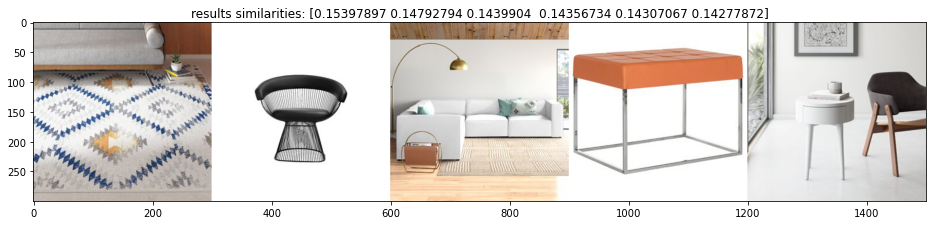

In [24]:
compare = preprocessing.normalize(
        fc1_extractor.predict(image_upload(Image.open('test/test1.jpg'), model.input_shape[1:3])[1]), norm="l2",
    ).reshape(4096,)
similarity_search(V_1_norm, compare, file_mapping)



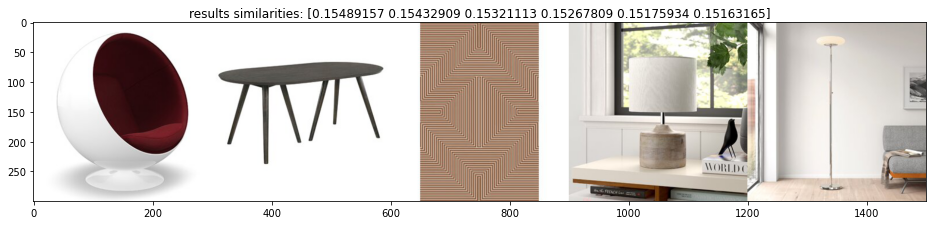

In [26]:
compare = preprocessing.normalize(
        fc1_extractor.predict(image_upload(Image.open('test/test3.jpg'), model.input_shape[1:3])[1]), norm="l2",
    ).reshape(4096,)
similarity_search(V_1_norm, compare, file_mapping)



## Using StyleStack to query results

In [353]:
stack = StyleStack.build('images', 'vgg16')


keeping 3882 image_paths to analyze
index time: 632.534 ms


In [363]:
stack1 = StyleStack.build('images/chairs', 'vgg16')

keeping 466 image_paths to analyze
index time: 277.067 ms


In [370]:
stack2 = StyleStack.build('images/sofa', 'vgg16')

keeping 479 image_paths to analyze
index time: 361.365 ms


In [450]:
embedding_weights = {
        'block1_conv1': 1,
        'block1_conv2': 1,
        'block1_pool': 0.5
        
}

results = stack.query('test/test3.jpg', embedding_weights)

{'block1_conv1': {291: 0.80681324, 197: 0.9029748, 1384: 0.7503888, 1613: 0.8940152, 1008: 0.9783728, 1178: 0.766639, 1850: 1.0}, 'block1_conv2': {291: 1.0, 197: 0.94745857, 1384: 0.76990706, 1613: 0.8996228, 1008: 0.84945387, 1178: 0.8253671, 1850: 0.9292654}, 'block1_pool': {291: 0.79324996, 197: 0.9751287, 1384: 0.8799053, 1613: 0.96321476, 1008: 0.8123392, 1178: 1.0, 1850: 0.9209682}}
{291: 2.2034382224082947, 197: 2.337997704744339, 1384: 1.9602485001087189, 1613: 2.2752453684806824, 1008: 2.233996272087097, 1178: 2.0920060873031616, 1850: 2.3897494673728943}
query time: 6.343 ms
[1384, 1178, 291, 1008, 1613]


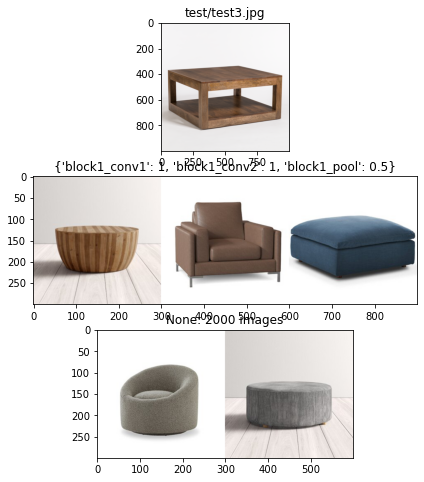

In [451]:
plot_results(results)